In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os
from sklearn.metrics import classification_report
import numpy as np
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
!pip install kagglehub


In [5]:
import kagglehub

# Download the dataset
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


In [6]:
from torchvision import datasets, transforms
import os

# This is the path you got from kagglehub
data_dir = "/kaggle/input/brain-tumor-mri-dataset"

# Define your transforms
data_transforms = {
    'Training': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
    'Testing': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
}

# Load the datasets
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['Training', 'Testing']
}

# Optional: Create dataloaders if you want to train/test later
from torch.utils.data import DataLoader

dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=32, shuffle=True)
    for x in ['Training', 'Testing']
}

print("Datasets loaded successfully! 🧠🔥")


Datasets loaded successfully! 🧠🔥


In [7]:
print(f"Training images: {len(image_datasets['Training'])}")
print(f"Testing images: {len(image_datasets['Testing'])}")



Training images: 5712
Testing images: 1311


In [8]:
# Dataset Transforms and Loading
data_transforms = {
    'Training': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'Testing': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
}

data_dir = '/kaggle/input/brain-tumor-mri-dataset'
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['Training', 'Testing']
}

dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=32, shuffle=True)
    for x in ['Training', 'Testing']
}

class_names = image_datasets['Training'].classes
print("Classes:", class_names)


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [9]:
# 🧠 CWAM Module
class CWAM(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(CWAM, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction_ratio),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction_ratio, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


In [10]:
# ResNet101 + CWAM Model
class ResNet101_CWAM(nn.Module):
    def __init__(self, num_classes):
        super(ResNet101_CWAM, self).__init__()
        self.backbone = models.resnet101(pretrained=True)
        self.features = nn.Sequential(*list(self.backbone.children())[:-2])
        self.cwam = CWAM(2048)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.cwam(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [12]:
# 🏁 Model Init, Loss, Optimizer
model = ResNet101_CWAM(num_classes=len(class_names)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 173MB/s]


In [15]:
# Training Loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in dataloaders['Training']:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.4f}")


Epoch 1/10, Loss: 0.8463
Epoch 2/10, Loss: 0.7197
Epoch 3/10, Loss: 0.2588
Epoch 4/10, Loss: 0.4557
Epoch 5/10, Loss: 0.3208
Epoch 6/10, Loss: 0.4781
Epoch 7/10, Loss: 0.2597
Epoch 8/10, Loss: 0.2661
Epoch 9/10, Loss: 0.1904
Epoch 10/10, Loss: 0.2336


In [16]:
#  Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders['Testing']:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print(classification_report(all_labels, all_preds, target_names=class_names))


              precision    recall  f1-score   support

      glioma       1.00      1.00      1.00       300
  meningioma       0.99      1.00      1.00       306
     notumor       1.00      1.00      1.00       405
   pituitary       1.00      1.00      1.00       300

    accuracy                           1.00      1311
   macro avg       1.00      1.00      1.00      1311
weighted avg       1.00      1.00      1.00      1311



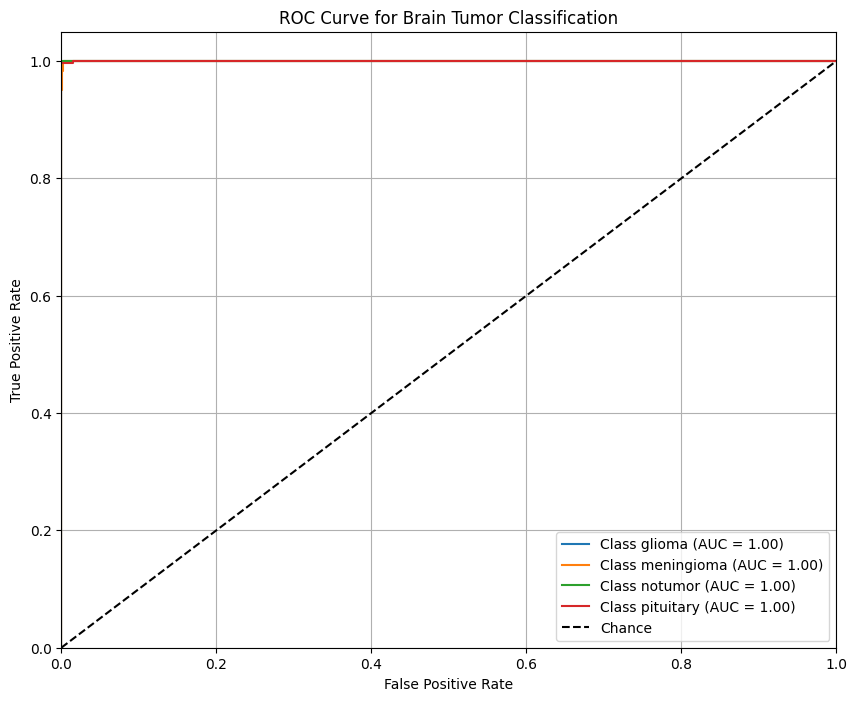

In [17]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import torch

# Step 1: Get model predictions and true labels
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in dataloaders['Testing']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        all_labels.append(labels.cpu())
        all_preds.append(outputs.cpu())

# Step 2: Convert to NumPy
all_labels_np = torch.cat(all_labels).numpy()
all_preds_np = torch.cat(all_preds).numpy()

# Step 3: Binarize true labels
n_classes = len(class_names)
y_test = label_binarize(all_labels_np, classes=range(n_classes))

# Step 4: Calculate ROC & AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], all_preds_np[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Step 5: Plot ROC Curve
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Brain Tumor Classification')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


<Figure size 800x600 with 0 Axes>

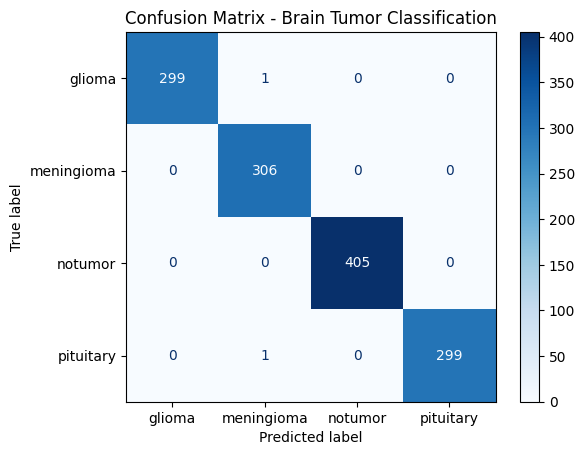

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
import numpy as np

# Set model to evaluation mode
model.eval()

all_preds = []
all_labels = []

# No gradient calculation needed for inference
with torch.no_grad():
    for inputs, labels in dataloaders['Testing']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Display
plt.figure(figsize=(8,6))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Brain Tumor Classification")
plt.show()


In [24]:
print(f"Files in Testing folder: {os.listdir('/kaggle/input/brain-tumor-mri-dataset/Testing')}")


Files in Testing folder: ['pituitary', 'notumor', 'meningioma', 'glioma']


In [26]:
import os

# Set your dataset path
dataset_path = "/kaggle/input/brain-tumor-mri-dataset/Testing"  # Specify the 'Testing' folder

# List the subfolders in the 'Testing' directory
subfolders = [folder for folder in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, folder))]
print(f"Subfolders in Testing: {subfolders}")


Subfolders in Testing: ['pituitary', 'notumor', 'meningioma', 'glioma']


Class name of the first image: pituitary
Shape (1, 150, 150, 3)


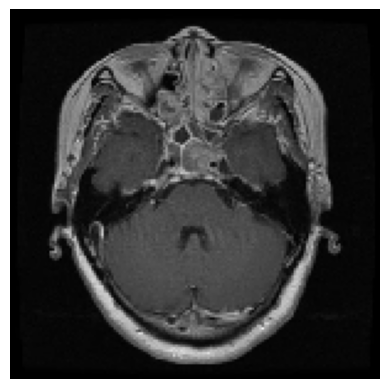

In [27]:
# Choose the first subfolder
first_class = subfolders[0]
first_class_path = os.path.join(dataset_path, first_class)

# List the image files in the subfolder
image_files = [f for f in os.listdir(first_class_path) if f.endswith('.jpg') or f.endswith('.png') or f.endswith('.jpeg')]

# Check if the directory contains image files
if not image_files:
    print(f"No image files found in {first_class_path}")
else:
    first_image_file = image_files[0]
    first_image_path = os.path.join(first_class_path, first_image_file)

    # Load and preprocess image
    image = load_img(first_image_path, target_size=(150, 150))
    image_array = img_to_array(image)
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

    # Print details
    print(f"Class name of the first image: {first_class}")
    print(f"Shape {image_array.shape}")

    # Plot the image
    plt.imshow(image)
    plt.axis("off")
    plt.show()
